The goal of this is to successfully complete all the steps necessary to enter the Dogs & Cats Kaggle competition, from start to finish. I am also aiming to actually achieve a rather high level in the competition. So the steps are:

1. Download the data from Kaggle
2. Use BASH commands to put the data into the appropriate folders (train, valid, sample, test)
3. Import the data into a NUMPY array and save it
4. Import the VGG model
5. Finetune the VGG model with our data
6. Save the model weights
7. Create the predictions using the finetuned VGG data
8. "trim" the probabilities, so none of the probabilities are too close to 0 or 1, which is heavily penalized
9. Save the predictions as a downloadable file, which I can then manually submit to Kaggle

## Download the data from Kaggle

In [12]:
%pwd
%matplotlib inline

In [14]:
cwd

'/Users/isaaclavine/fastai/courses/deeplearning1/nbs/data/redux'

In [13]:
import os, sys
cwd = os.getcwd()

In [15]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [16]:
# Importing modules
from shutil import copyfile
from utils import *
import keras
from vgg16 import Vgg16

In [17]:
%cd data/redux/

[Errno 2] No such file or directory: 'data/redux/'
/Users/isaaclavine/fastai/courses/deeplearning1/nbs/data/redux


In [ ]:
## Just having a filler here from now - we will use the Kaggle CLI
kg download -u lavinei -p changeme -c dogs-vs-cats-redux-kernels-edition

In [ ]:
# Not sure the 'line magic' will allow me to use a more advanced function like unzip
%unzip train
%unzip test

## Use BASH commands to put the data into the appropriate folders (train, valid, sample, test)

In [18]:
## Again this is a filler - already have everything in the appropriate folder
## But when I do this in the future, I think it'd be better to use Python commands to randomize the sample

DATA_HOME_DIR = cwd+'/data/redux'
if not os.path.exists(DATA_HOME_DIR): os.mkdir(DATA_HOME_DIR)

OSError: [Errno 2] No such file or directory: '/Users/isaaclavine/fastai/courses/deeplearning1/nbs/data/redux/data/redux'

In [ ]:
%cd $DATA_HOME_DIR

In [ ]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir test
%mkdir train
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

In [ ]:
# Now going into the train folder
# Going to MOVE some files into the validation folder
# Going to COPY some files into the samples folder
%cd $DATA_HOME_DIR/train

In [ ]:
# This will move images to the validation folder
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in xrange(2000): os.rename(shuf[i], DATA_HOME_DIR + '/valid/' + shuf[i])

In [ ]:
# This will copy images to the sample folder
from shutil import copyfile
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in xrange(100): copyfile(shuf[i], DATA_HOME_DIR + '/sample/train/' + shuf[i])

In [ ]:
# Now we want to move some validation images into the sample/valid folder
%cd $DATA_HOME_DIR/valid
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in xrange(100): copyfile(shuf[i], DATA_HOME_DIR + '/sample/valid/' + shuf[i])

In [ ]:
# Now move everything in test into the 'unknown' folder
%cd $DATA_HOME_DIR/test

In [ ]:
%mv *.jpg unknown/

## Move everything into folders for 'dogs' and 'cats'

In [ ]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

## Import the data into a NUMPY array and save it

In [43]:
# Switch between the sample and the real path
#path = DATA_HOME_DIR + '/'
path = DATA_HOME_DIR + '/sample/'

test_path = path + 'test/' # Technically this should always point to the true test path
# no real reason to have a 'sample' testing folder, doesn't gain anything
results_path = path + 'results/' #
train_path = path + 'train/'
valid_path = path + 'valid/'

In [44]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=16
no_of_epochs=3

batches = get_batches(path + 'train', batch_size = batch_size)
val_batches = get_batches(path + 'valid', batch_size = batch_size)

Found 200 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


## Import the VGG model

In [23]:
#import Vgg16 helper class
vgg = Vgg16()

In [24]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

## Finetune the VGG model with our data

In [26]:
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.001

In [27]:
no_of_epochs=1
vgg.fit(batches, val_batches, nb_epoch = no_of_epochs)

Epoch 1/1
200/200 [==============================] - 76s - loss: 0.7825 - acc: 0.7650 - val_loss: 0.1045 - val_acc: 0.9592


## Save the model weights

In [ ]:
latest_weights_filename = 'finetune%d.h5' % no_of_epochs

vgg.model.save_weights(results_path + latest_weights_filename)

## Create the predictions using the finetuned VGG Data

In [ ]:
test_batches, preds = vgg.test(test_path, batch_size = batch_size)

In [ ]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Make a model with Keras's Sequential Library

In [45]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(axis=1),
        Dense(512, activation='relu'),
        BatchNormalization(axis=1),
        Dense(2, activation='softmax')
        ])

model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_7 (BatchNorma (None, 3, 224, 224)   12          batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 32, 222, 222)  896         batchnormalization_7[0][0]       
____________________________________________________________________________________________________
batchnormalization_8 (BatchNorma (None, 32, 222, 222)  128         convolution2d_18[0][0]           
____________________________________________________________________________________________________
convolution2d_19 (Convolution2D) (None, 32, 220, 220)  9248        batchnormalization_8[0][0]       
___________________________________________________________________________________________

In [48]:
nb_epoch = 1
model.fit_generator(generator = batches, samples_per_epoch = batches.nb_sample,
                    nb_epoch=nb_epoch, validation_data = val_batches, nb_val_samples = val_batches.nb_sample)

Epoch 1/1
200/200 [==============================] - 94s - loss: 2.8986 - acc: 0.6550 - val_loss: 6.8347 - val_acc: 0.5102


## Save the Model

In [ ]:
# Save the model
filename = 'model1.h5'

model.save(results_path + filename)

In [ ]:
# Load the model
model = keras.models.load_model(results_path + filename)

## Make a model with Keras's Functional Library

In [57]:
inputs = Input(shape = (3, 224, 224,))
# Convolutional layer # 1
x = BatchNormalization(axis=1)(inputs)
x = Convolution2D(64, 3, 3)(x)
x = MaxPooling2D()(x) 
# Convolutional Layer # 2
x = BatchNormalization(axis=1)(x)
x = Convolution2D(64, 3, 3)(x)
x = MaxPooling2D()(x)

# Now 2 dense layers
x = Flatten()(x) 
x = BatchNormalization(axis=1)(x)
x = Dense (1000, activation="relu")(x)
x = Dropout(0.6)(x)
x = BatchNormalization(axis=1)(x)
x = Dense (1000, activation="relu")(x)
x = Dropout(0.6)(x)

# And a softmax output
predictions = Dense (2, activation="softmax")(x)

In [58]:
model_functional = Model(input = inputs, output = predictions)
model_functional.compile(optimizer=Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [61]:
batches.image_shape

(3, 224, 224)

In [60]:
nb_epoch = 1
model_functional.fit_generator(generator = batches, samples_per_epoch = batches.nb_sample,
                    nb_epoch=nb_epoch, validation_data = val_batches, nb_val_samples = val_batches.nb_sample)

Epoch 1/1
200/200 [==============================] - 53s - loss: 1.3310 - acc: 0.5400 - val_loss: 7.5111 - val_acc: 0.5306


Benefits of the functional library:
 - Allows merging of multiple types of input (either by concatenation, or dot product)
 - Allows blocks of a model to be re-used, particularly for a Recurrent Neural Network (RNN)

## Validate the results visually

We're going to start by visually validating the results with the validation test (naturally)!

In [28]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

In [29]:
## Making predictions on the validation set
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 98 images belonging to 2 classes.


In [31]:
filenames = val_batches.filenames
expected_labels = val_batches.classes

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,1]
our_labels = np.round(our_predictions)

Found 94 correct labels


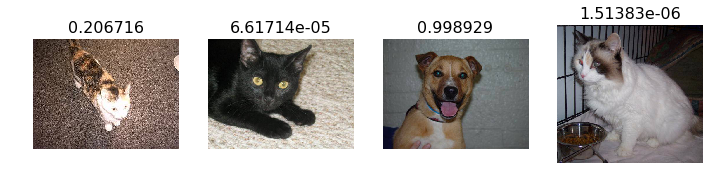

In [49]:
## A few random correct predictions
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 4 incorrect labels


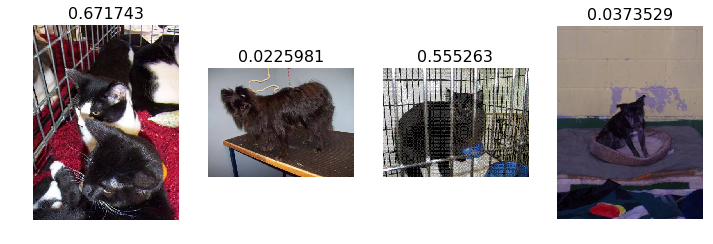

In [50]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

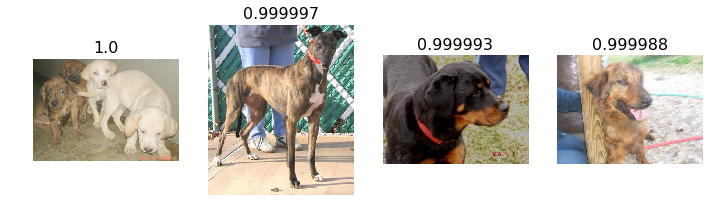

In [35]:
## The most confident (and correct) dogs
correct_dogs = np.where((our_labels == 1) & (expected_labels == 1))[0]
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[::-1][:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

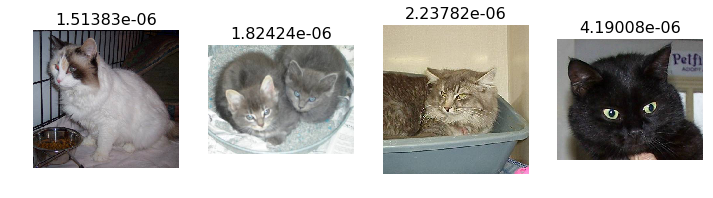

In [36]:
## The most confident (and correct) cats
correct_cats = np.where((our_labels == 0) & (expected_labels == 0))[0]
most_correct_cats = np.argsort(-our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

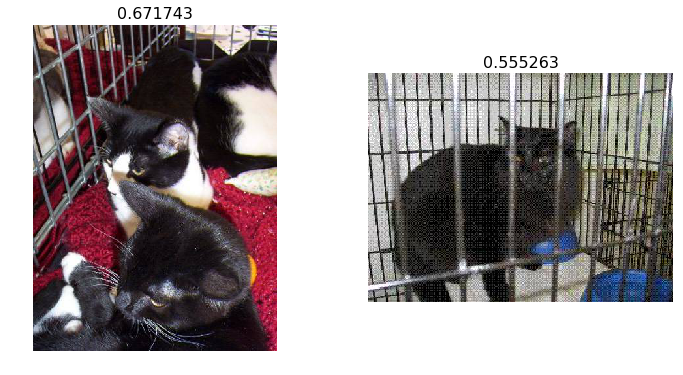

In [37]:
## The most confident, incorrect, cats
incorrect_cats = np.where((our_labels == 1) & (expected_labels == 0))[0]
most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

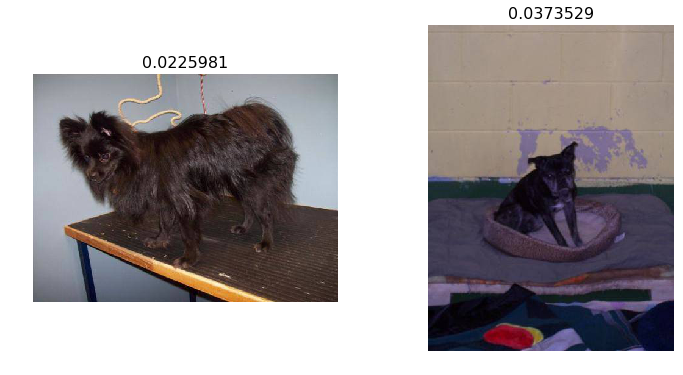

In [38]:
## The most confident, incorrect, dogs
incorrect_dogs = np.where((our_labels == 0) & (expected_labels == 1))[0]
most_incorrect_dogs = np.argsort(-our_predictions[incorrect_dogs])[::-1][:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

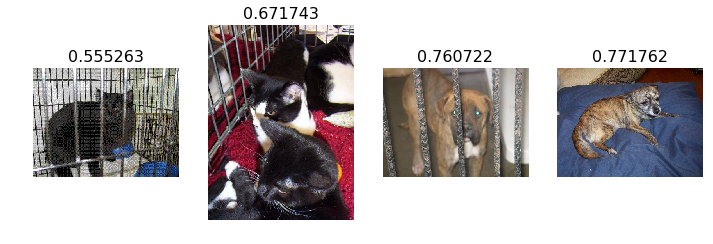

In [39]:
## The most uncertain labels
#uncertain = np.where((0.3 < our_predictions < 0.7)[0]
most_uncertain = np.argsort(-abs(0.5 - our_predictions))[::-1][:n_view]
plots_idx(most_uncertain, our_predictions[most_uncertain])

## Trim the probabilities so that none are too close to 0 or 1

In [38]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

IOError: [Errno 2] No such file or directory: '/Users/isaaclavine/fastai/courses/deeplearning1/nbs/data/redux/sample/results/test_preds.dat/meta/sizes'

In [ ]:
isdog = preds[:,1]
isdog = isdog.clip(min=0.05, max=0.95)

## Save the predictions as a downloadable file

The format that Kaggle is expecting is an array with 2 columns: The Image ID, and the probability of is_Dog. For us, is_Dog is the 2nd column in our predictions

The format that Kaggle is expecting is an array with 2 columns: The Image ID, and the probability of is_Dog

In [ ]:
#Extract imageIds from the filenames in our test/unknown directory 
#filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [ ]:
filenames[6000:6005]

In [ ]:
subm = np.stack([ids,isdog], axis=1)

In [ ]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [ ]:
from IPython.display import FileLink
#%cd $LESSON_HOME_DIR
FileLink(submission_file_name) # Having trouble making this work

In [ ]:
## If we want to do a Kaggle command:
#kg submit -u lavinei -p changeme -c dogs-vs-cats-redux-kernels-edition submission1.csv

In [ ]:
??np.correlate

In [ ]:
a = np.array([1, 2, 3])

In [ ]:
b = np.array([(1, 2, 3), (4, 5, 6)])

In [ ]:
b

In [ ]:
#np.convolve(a, b)
b[::-1]